# Assignment 1 Group XX
## Question 1


In [40]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from portfolio import Portfolio_Optimizer


In [41]:
index_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='indices',index_col='date')
fx_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='currencies',index_col='date')
weight_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='market_cap')

index_df.head()

,SPTSX INDEX,CAC INDEX,DAX INDEX,SX5E INDEX,NKY INDEX,UKX INDEX,SPX INDEX,IBOV INDEX
date,,,,,,,,
03/30/2007,13165.500000,5634.160156,6917.029785,4181.029785,17287.650391,6308.03,1420.86,45805
04/02/2007,13265.799805,5645.560059,6937.169922,4189.549805,17028.410156,6315.53,1424.55,45597
04/03/2007,13361.200195,5711.910156,7045.560059,4246.299805,17244.050781,6366.11,1437.77,46288
04/04/2007,13448.299805,5739.009766,7073.910156,4261.830078,17544.089844,6364.70,1439.37,46554
04/05/2007,13425.000000,5741.379883,7099.910156,4271.540039,17491.419922,6397.34,1443.76,46647


In [42]:
# convert to dollar
for index in index_df.columns:
    curr = weight_df[weight_df['Ticker'] == index]['Currency'].to_string()[-3:]
    index_df[index] = index_df[index]*fx_df[curr]

In [43]:
logreturns_df = np.log(index_df) - np.log(index_df.shift(1))

mean_values = logreturns_df.mean()
std_deviation = logreturns_df.std()
kurtosis_values = logreturns_df.kurtosis()
skewness_values = logreturns_df.skew()

statistics_table = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_deviation,
    'Kurtosis': kurtosis_values,
    'Skewness': skewness_values
})

statistics_table

,Mean,Standard Deviation,Kurtosis,Skewness
SPTSX INDEX,0.000117,0.015251,12.306159,-0.866287
CAC INDEX,0.000025,0.018352,17.583211,0.372231
DAX INDEX,0.000207,0.018058,16.916223,0.410990
SX5E INDEX,-0.000041,0.018481,16.980611,0.283744
NKY INDEX,0.000165,0.016163,16.738605,-0.552431
UKX INDEX,-0.000065,0.015374,10.097418,-0.274447
SPX INDEX,0.000374,0.013581,12.021852,-0.637743
IBOV INDEX,-0.000060,0.024794,11.078068,-0.154794


In [44]:
# Shapiro-Wilk Test
for col in logreturns_df.columns:
    shapiro_stat, shapiro_p_value = shapiro(logreturns_df[col])
    print('p-value for '+col+':', shapiro_p_value)


p-value for SPTSX INDEX: 1.0
p-value for CAC INDEX: 1.0
p-value for DAX INDEX: 1.0
p-value for SX5E INDEX: 1.0
p-value for NKY INDEX: 1.0
p-value for UKX INDEX: 1.0
p-value for SPX INDEX: 1.0
p-value for IBOV INDEX: 1.0


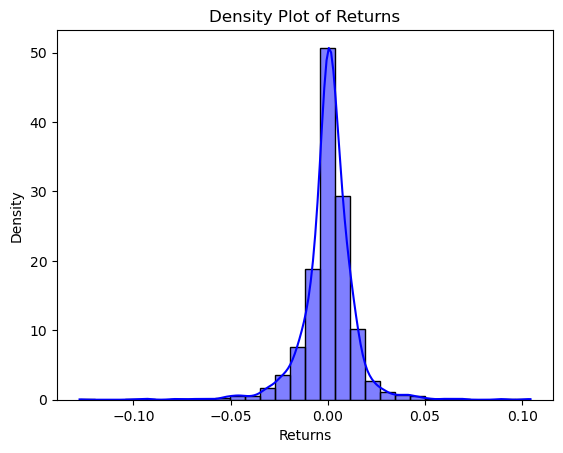

In [45]:
# Assuming 'returns_df' is already defined from your previous code
returns_column = logreturns_df['SPX INDEX']  # Replace 'YourColumnName' with the actual column name

# Plot the density
sns.histplot(returns_column, kde=True, bins=30, color='blue', stat='density')
plt.title('Density Plot of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()


## Question 2 

In [22]:
returns_df = index_df.pct_change().dropna()

portfolio = Portfolio_Optimizer(returns_df)

In [48]:
market_cap_weights = np.array(weight_df['MktCap%'])

custom_weigths = {
    'Mkt Cap Weighted Portfolio': market_cap_weights
}

portfolio.performance_summary(custom_weights=custom_weigths)


Max Sharpe Portfolio:
   - Return: 0.10479054925991783
   - Standard Deviation (Risk): 0.17650261073944815

Min Variance Portfolio:
   - Return: 0.09390923670506174
   - Standard Deviation (Risk): 0.1714903805307943

Equal Weight Portfolio:
   - Return: 0.06216202345229385
   - Standard Deviation (Risk): 0.22268786570377302

Mkt Cap Weighted Portfolio:
   - Return: 0.08969246261501455
   - Standard Deviation (Risk): 0.19599724489887774


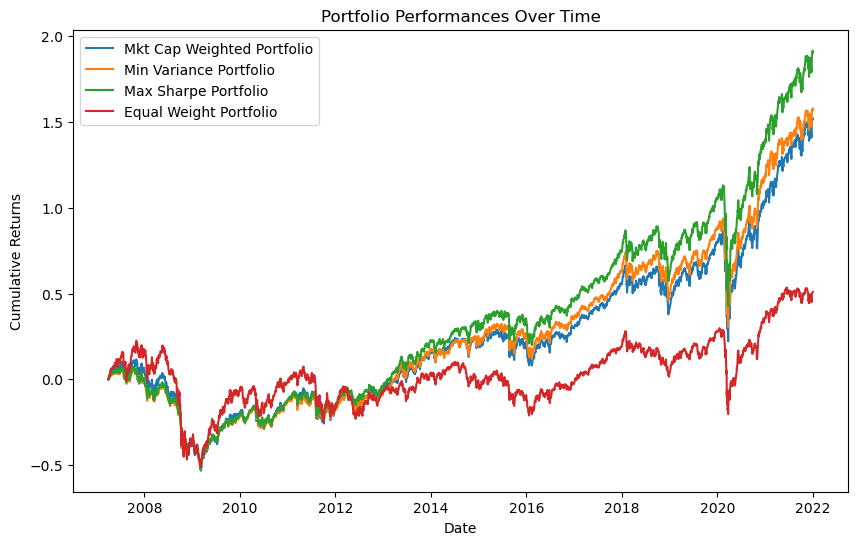

In [24]:
portfolio.plot_performance(index_df, custom_weights=custom_weigths)

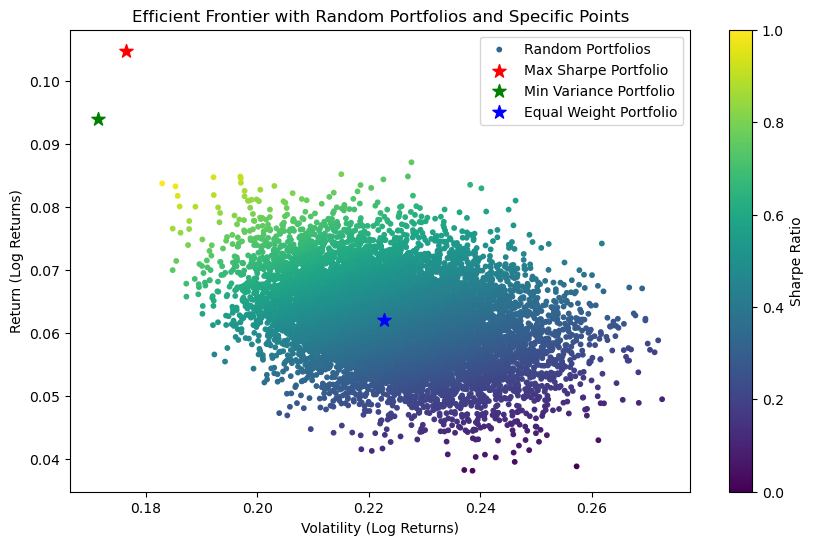

In [25]:
portfolio.plot_efficient_frontier(10000)

## Question 3

In [36]:


rw_returns_df = returns_df.loc['02/01/2010':'01/12/2014']


window_size = len(rw_returns_df)/5

KeyError: '01/01/2014'